# Challenge Details
Explore the risk factors and their combinations to predict the risk of breast cancer. We would like to see the most accurate risk factor analysis through this challenge outcome.

The provided dataset includes participant characteristics previously shown to be associated with breast cancer risk estimation including **age, race/ethnicity, age at first birth, breast density, mammogram result, use of hormone replacement therapy, menopausal status, surgical menopause, body mass index, breast procedure, and diagnosis of invasive breast cancer**.
These data can be used to describe the distribution of breast cancer risk in the general population or to explore relationships among breast cancer risk factors.
You need to **prepare and train a model** using the provided **training dataset**. This should **predict the breast cancer** result for the input **testing dataset**.

## DATASET DETAILS
In this challenge, you will work with a csv file that contains a risk estimation dataset for breast cancer. The data dictionary is also provided for the format of the dataset used in this challenge. The **original dataset is partitioned into training, provisional and final testing datasets**, in which the training dataset contains the column “cancer” indicating the **actual breast cancer result (0 = no & 1 = yes)**.

**Note:** "Data collection and sharing was supported by the National Cancer Institute-funded Breast Cancer Surveillance Consortium (HHSN261201100031C). You can learn more about the BCSC at: **http://www.bcsc-research.org/.** Data for this study was obtained from the BCSC: **http://bcsc-research.org/.**"

## RESOURCES
All required files for this challenge can be downloaded from the shared location **here**. Please find the details below:

**data-training.zip:** The full training dataset which must be used to train the model.

**data-provisional.zip:** The provisional testing dataset. Your submissions must contain prediction data from this dataset.

**sample-submission.zip:** A sample submission package to illustrate the required submission format.

**Data Dictionary:** It contains the descriptions of the format and content of the training data. It can be accessed online here.

**Data Stratification:** The original dataset is partitioned into training, provisional and final testing datasets by randomly considering id column as row identifier.


## SOLUTION REQUIREMENTS
Your solution can be in C/C++, Python or any programming language.
The project submission shall **include a description and theory behind any preprocessing algorithm used to transform the ‘raw’ data before it is used by the correlation algorithms**.

**Solution output must be a csv file having two columns as:**
**id:** The identifier column value must match the corresponding row in the input testing file.
**prediction:** The predicted data for the breast cancer probability values as float numbers within range [0,1].

## SUBMISSION FORMAT
The required format of the submission package is specified in a submission template document. This current document gives only requirements that are either additional or override the requirements listed in the template.

Submit your source code as a zip file for final scoring and a solution file for provisional scoring. Please refer sample-submission.zip file for the expected folder structure and required files for the submission scoring.
The output of your algorithm should be a single csv file that lists the prediction result for each row in the input dataset.
Please update Dockerfile for the prerequisite software stack used in the solution and the README file as appropriate, explaining changes to folder structure, updated software stack and relevant packages and versions, as well as instructions on how to run your algorithm. Please also include any references used in your README file.
Winners may be asked to submit a separate whitepaper.
Your output must only contain algorithmically generated detections. It is strictly forbidden to include hand labeled data, or data that - although initially machine generated - is modified in any way by a human.

## SCORING DETAILS
During scoring, your output files (as contained in your submission file during provisional testing, or generated by your docker container during final testing) will be matched against the expected ground truth data using the following method.

If your solution is invalid (e.g. if the tester tool can't successfully parse its content or if it violates the constraints listed in the Output File section), you will receive a score of -1.
We are going to mainly evaluate your method based on the AUC score. We would like to see a model achieving a great balanced score.

In [276]:
import pandas as pd
import numpy as np
from google.colab import files
import matplotlib.pyplot as plt 
# from matplotlib import style
import seaborn as sns
# sns.set_style('whitegrid')
from xgboost import XGBClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import learning_curve
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import resample # for resampling our dataset
import lightgbm as lgb
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline
import time


In [277]:
# dataset = files.upload()

### Understanding the data
I load the dataset and inspect for **shape** of the dataset, **datatypes**, **number of columns** and **rows**. Check for **missing values**, **duplicated values**, the **statistical distribution** of the data

In [278]:
df = pd.read_csv('/content/data-training.csv')
df2 = df.copy()
df.head()


,id,menopaus,agegrp,density,race,Hispanic,bmi,agefirst,nrelbc,brstproc,lastmamm,surgmeno,hrt,invasive,cancer,count
0,RE-TRAIN-0000001,0,1,1,1,0,1,0,0,0,9,9,9,0,0,2
1,RE-TRAIN-0000002,0,1,1,1,0,1,0,0,0,9,9,9,0,0,4
2,RE-TRAIN-0000003,0,1,1,1,0,1,0,1,0,0,9,9,0,0,1
3,RE-TRAIN-0000004,0,1,1,1,0,1,0,1,0,9,9,9,0,0,1
4,RE-TRAIN-0000005,0,1,1,1,0,1,1,0,0,0,9,9,0,0,2


In [279]:
# for submission, this code is irrelevant
X1 = df.drop(['cancer'], axis=1)
y1 = df['cancer']

# Splitting to get index for submission
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.20, random_state=42)


In [281]:
df['cancer'].value_counts()

0    189942
1      6520
Name: cancer, dtype: int64

In [282]:
df.columns.values

array(['id', 'menopaus', 'agegrp', 'density', 'race', 'Hispanic', 'bmi',
       'agefirst', 'nrelbc', 'brstproc', 'lastmamm', 'surgmeno', 'hrt',
       'invasive', 'cancer', 'count'], dtype=object)

In [283]:
df.columns.unique()

Index(['id', 'menopaus', 'agegrp', 'density', 'race', 'Hispanic', 'bmi',
       'agefirst', 'nrelbc', 'brstproc', 'lastmamm', 'surgmeno', 'hrt',
       'invasive', 'cancer', 'count'],
      dtype='object')

The Data is already cleaned and there are no duplicated values. Data have been vectorized for machine learning to follow

We Will proceed to drop columns that do not related to the target variable, "cancer"

# Univariate Analysis 

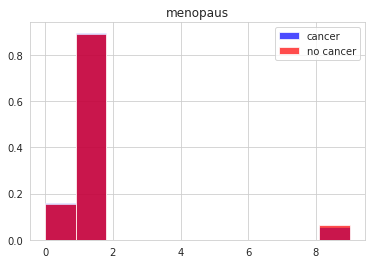

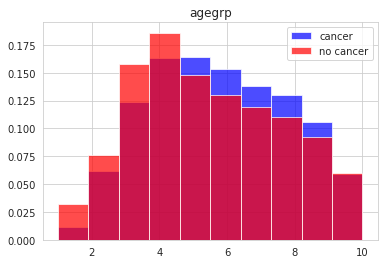

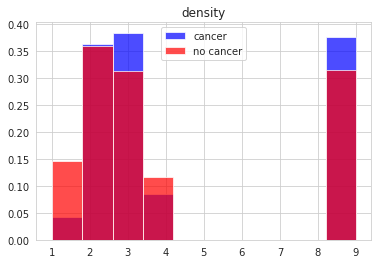

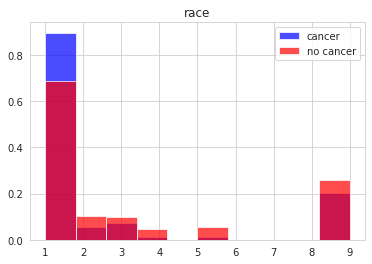

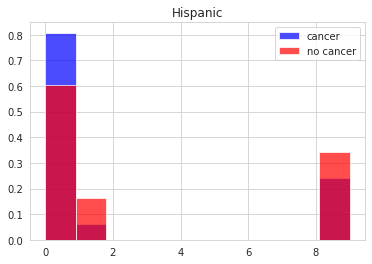

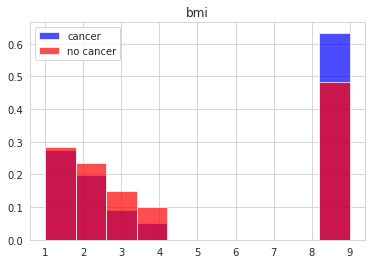

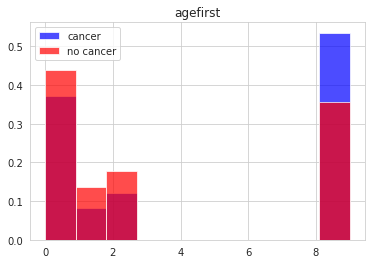

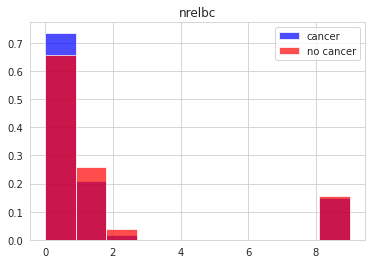

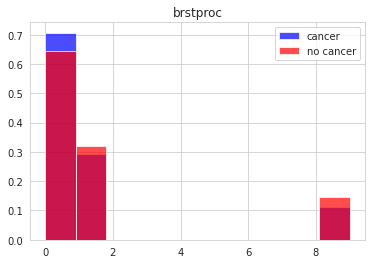

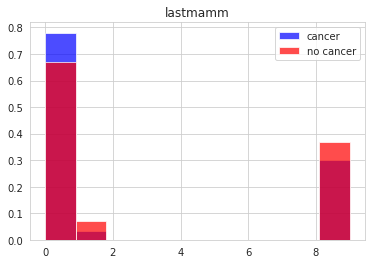

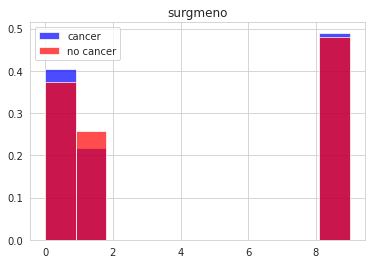

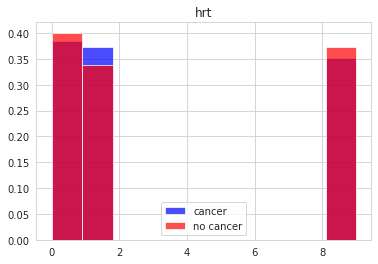

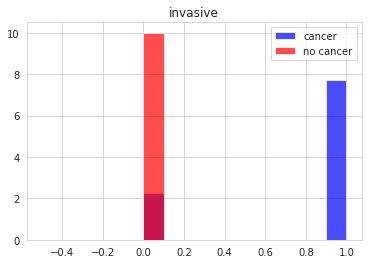

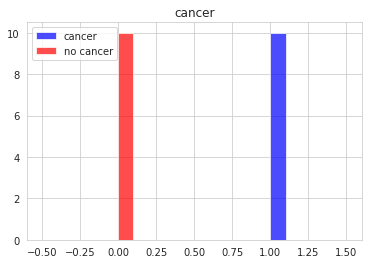

In [285]:
for label in df.columns[1:-1]: # We loop through the columns to in the columns from the dataset
  plt.hist(df[df['cancer']==1][label], color='blue', label='cancer', alpha=0.7, density=True) # Get every features where the target is 1, i.e., cancer.
  plt.hist(df[df['cancer']==0][label], color='red', label='no cancer', alpha=0.7, density=True) # Get every features in the dataframe where the target is 0, no cancer.
  plt.title(label)
  plt.ylabel='Probability' # It is probability because the density is True
  plt.xlabel=(label)
  plt.legend()
  plt.show()

# Age Group
The graphs above shows that there are almost a normal distribution of the cancer cases across all the age groups in the dataset with a quite higher cases among age groups between 40years and older people.

# Breast Density
As for the breast density, there seem to be a higher likelihood of women with higher breast density being diagnosed with cancer than those with lower breast densisty

# Race/Hispanic
The dataset reveals a higher record of cancer cases among the Hispanic race more than other races

# BMI
It appears that the BMI measure, has an equal likelihood a person will be diagnosed to have developed a breast cancer or not
.


# Scaling the Dataset
We will need to scale the dataset and oversample it so as to have an equal size of both cancer diagnosis. 

We will also form a 2D dataframe from the dataset and stack them by stacking them horizontally. In this case we will have to increase the dimension of the target variable, y by applying the reshape method in order to align with numpy dimensionality rule.

So we used the MinMaxScaler form Sklearn to scale the dataset, RandomOverSample to increase the dataset to have an equal representation of the two cancer diagnosis.

In [286]:
# Let's pick a class size of roughly half the size of the largest size
class_size = 60000
# Let's list the target labels
labels_counts = df['cancer'].value_counts().to_dict() # create a dict with the setiment  as keys and counts as values

In [287]:
resampled_classes = []

# For each label
for label, label_size in labels_counts.items():
    # If label_size < class size then set replace to True to upsample, else False to downsample
    if label_size < class_size:
        # Upsample
        replacement = True # sample with replacement (we need to duplicate observations)
    else:
        # Downsample
        replacement = False # sample with replacement (we need to duplicate observations)
    label_data = df[df['cancer'] == label]
    label_resampled = resample(label_data,
                               replace=replacement, # sample without replacement (no need for duplicate observations)
                               n_samples=class_size, # number of desired samples
                               random_state=27) # reproducible results

    resampled_classes.append(label_resampled) # add to the resampled_classes list the sampled dataframe

In [288]:
resampled_data = pd.concat(resampled_classes, axis=0) # add the dataframes for the list together to have a final dataframe
print(resampled_data.shape) # view the dataframe

(120000, 16)


In [289]:
resampled_data.head()

,id,menopaus,agegrp,density,race,Hispanic,bmi,agefirst,nrelbc,brstproc,lastmamm,surgmeno,hrt,invasive,cancer,count
78257,RE-TRAIN-0078258,1,5,2,9,9,3,0,0,0,0,9,1,0,0,6
102609,RE-TRAIN-0102610,1,6,2,5,0,4,2,9,1,0,0,0,0,0,1
164239,RE-TRAIN-0164240,1,9,2,3,0,4,0,0,1,0,0,9,0,0,1
74126,RE-TRAIN-0074127,1,5,2,1,1,3,9,2,0,0,9,0,0,0,1
119855,RE-TRAIN-0119856,1,7,1,9,0,2,9,0,0,0,1,1,0,0,1


In [291]:
# Splitting the dataset into Train, Validation and Test sets
# train, valid, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])
X = resampled_data.drop(['cancer'], axis=1)
y = resampled_data['cancer']

In [292]:
X_train, X_test, y_train,  y_test =  train_test_split(X, y, test_size=0.20, random_state=42)

In [293]:
X_train2 = X_train.copy()
X_test2 = X_test.copy()

In [294]:
# Dropping the 'id' in the X_train nd X_test to be used as a DataFrame
X_train = X_train.drop(['id'], axis=1)
X_test = X_test.drop(['id'], axis=1)

# Creating a copy of the new dataset
X_train3 = X_train.copy()
X_test3 = X_test.copy()

In [295]:
# non_categ = ['menopaus', 'agegrp', 'density', 'race', 'Hispanic', 'bmi', 
      #  'agefirst', 'nrelbc', 'brstproc', 'lastmamm', 'surgmeno', 'hrt',
      #  'invasive', 'cancer', 'count']

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
                      
X_train = pd.DataFrame(X_train,columns=X_train3.columns)
X_test = pd.DataFrame(X_test,columns=X_test3.columns)

# Using Extreme Gradient Boost Model (XGBoost)

In [297]:
xgb = XGBClassifier(max_depth = 8, learning_rate = 0.025, n_estimators=1400, reg_lambda=0.8, reg_alpha=0.8, booster='gbtree') #, max_depth=50) # Initialize xgboost model
training_start = time.perf_counter() # Initialize start time for training the model
xgb.fit(X_train, y_train) # Fit training set to the model
training_end = time.perf_counter() # Initialize end time for the traing sets

start_prediction = time.perf_counter() # Initialize start time for prediction
y_pred = xgb.predict(X_test) # Test the model with the test set
end_prediction = time.perf_counter() # Initialize end time for prediction

accuracy = (y_pred == y_test).sum().astype(float) / len(y_pred)*100 # Measure accuracy of the model prediction
train_time = training_end - training_start # Measure duration for the traing 
prediction_time = end_prediction - start_prediction # Measure duration for the prediction

print("XGBoost's prediction accuracy is: %3.2f" % (accuracy)) # Print accuracy result
print("Time consumed for training: %4.3f" % (train_time)) # Print training duration
print("Time consumed for prediction: %6.5f seconds" % (prediction_time)) # Print prediction time


XGBoost's prediction accuracy is: 99.42
Time consumed for training: 233.604
Time consumed for prediction: 4.57472 seconds


XGBoost gave us an accuracy level of 99.42% within 233.604 training time and 4.57472 prediction time.

In [301]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     12201
           1       0.99      1.00      0.99     11799

    accuracy                           0.99     24000
   macro avg       0.99      0.99      0.99     24000
weighted avg       0.99      0.99      0.99     24000



The best performing model among the three models in terms of accuracy is the XGBooost model, followed by the KNN model. 

In terms of the time performance, XGBoost took the longest time training the datasets but the shortest time during the prediction phase. 

In [302]:
# y_pred = pd.DataFrame(y_pred, columns=['y_pred']).to_csv('prediction.csv')
# Save predictions in format used for competition scoring
output = pd.DataFrame({'Id': X_test2['id'],
                       'Cancer': y_pred})
output.to_csv('Solution.csv', index=False)